In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In this notebook, we try to code backproagation manucally yo understand it better. 

This [article](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b) is really good.


### Detaour to Backpropagation

In [6]:
z = 1/(1 + np.exp(-np.dot(W, x))) # forward pass
dx = np.dot(W.T, z*(1-z)) # backward pass: local gradient for x
dW = np.outer(z*(1-z), x) # backward pass: local gradient for W


NameError: name 'W' is not defined

In [2]:
words = open('../data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')


In [8]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)  # embedding matrix

W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) *  (5/3) / ((n_embd * block_size)**0.5)# input weights
b1 = torch.randn(n_hidden, generator=g) * 0.1 # input biases not-zero becasue we wantt to unmask it

W2 = torch.randn((1,n_hidden), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1 # 

# BatchNorm aprams
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True


2473


In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [11]:
batch_size = 32
n = batch_size

# construct a minibatch
ix = torch. randint(0, Xtr.shape[0], (n,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [12]:
# forward pass, here we want to expand the forward pass to get the intermediate tensors
# we will need them for the backward pass to run manually

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm
bmeani = 1/n * hprebn.sum(0, keepdim=True) # batch mean
bndiff = hprebn - bmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # Bessel correction with n-1 instead of n
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

#non-linearity
h = torch.tanh(hpreact) # hidden layer activation

# linear layer 2
logits = h @ W2 + b2 # logits

# corss entropy loss
# first we subtract the maximum value from the logits for numerical stability
# otherwise some of the logits could take large values and the exponential of the logits could explode
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # for numerical stability
counts = norm_logits.exp() # get the counts
counts_sum = counts.sum(1, keepdim=True) # normalise the counts to get probabilities
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean() # plucks out the probilies at for the column of the correct next character in the sequence. 
# Yb us tensor with index of the correct class
# it selects the 8th column at first row, 14th column at second row, etc.


# tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
#         26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

# backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, 
          norm_logits, logit_maxes, logits, h, hpreact, bnraw, 
          bnvar_inv, bnvar,bndiff, bndiff2, bmeani, hprebn, embcat, emb]:
    t.retain_grad()
loss.backward()
loss




tensor(3.3432, grad_fn=<NegBackward0>)

In [14]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [ ]:
# logprobs[] is the probabilities on th elog scale. loss is the -logprob[range(n), Yb]. we need to take derivative of the loss

# loss = -1/3a + -1/3b + -1/3c
# dloss/da = -1/n

In [ ]:
# derivative of count_sum_inv is two operations applied sequentially
# in the first operation broadcasting is used due to different shape
# exampel:
# c = a * b, but wiht tensors
# a[3x3] * b[1x3] = c[3x3]
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# in the second operation we sum the counts_sum_inv along the rows,
# local derivative is counts * dprobs 
# then we need to multiply this with derivative of the * operator whihc is sum across the rows
# finally we use keepdim=True to keep the dimensions of the tensor the same
# dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # derivative of the sum operation


In [22]:
counts.shape, counts_sum.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]), torch.Size([32, 1]))

In [ ]:
# lets do the derivative of counts_sum = counts.sum(1, keepdim=True)
# counts i 32x27 and counts_sum is 32x1
# this operation counts.sum(1, keepdim=True) is summing the counts along the rows like below
# a11 a12 a13  -> b1 (=a11+a12+a13)
# a21 a22 a23  -> b2 (= a21+a22+a23)
# a31 a32 a33 -> b3 (= a31+a32+a33)
# in the backprop, we need to take the derivative of the loss with respect to a
# how b depends on a?
# local derivative of the sum operation is 1, and with chain rule we get dloss/da = dloss/db * db/da
# addition is a router, the graddient just flows to all elements horizontally
# we we take dcounts_sum (column tensor) and  replicated 27 times
# for the replication we use torch.one_like(counts) which creates a tensor with the same shape as counts but with all elements set to 1
# finally we multiply the two tensors elementwise
# dcounts = torch.ones_like(counts) * dcounts_sum
# since dcounts is already calculated in another branch so we need to add them up, i.e.
# dcounts += torch.ones_like(counts) * dcounts_sum


backward pass for the expression $logits = h @ W2 + b2 $ is 


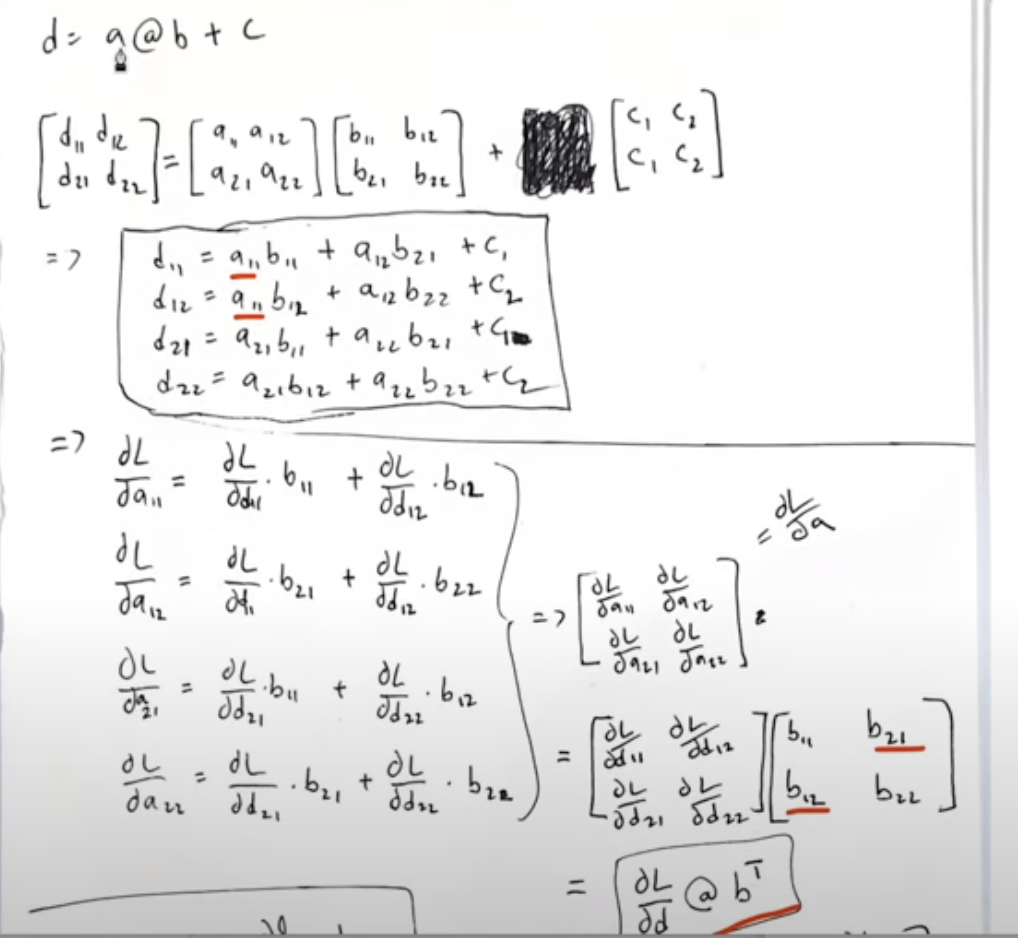
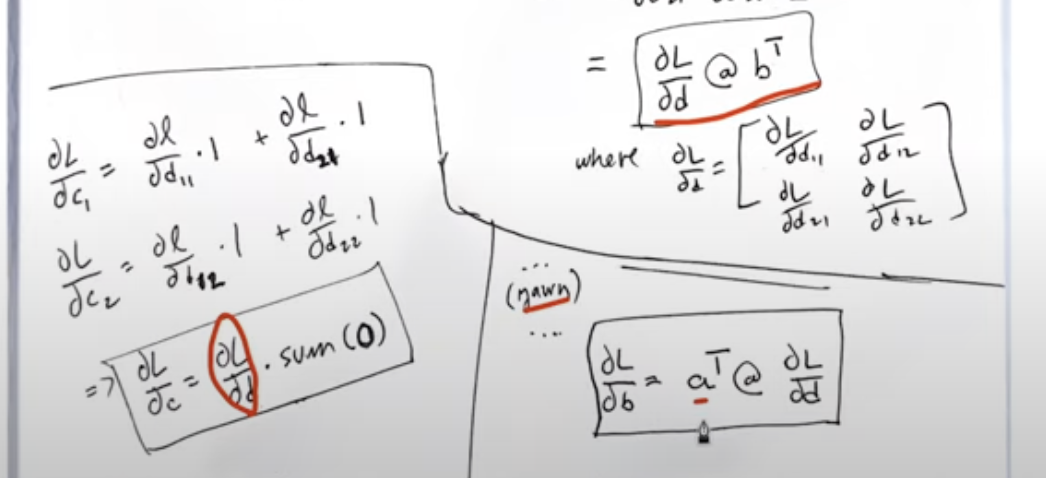

So simply we have dlogits and we multiply it with transpose of W
dlogits @ W2.T


In [28]:
# backprop manually 
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n # derivative of the loss w.r.t. the log probabilities
# next is dprobs it is the derivative of probs w.r.t. logprobs. local deravative of log oeprator which takes in probs and outputs logprobs
# dprob is the local derivative of the log oepration time the outout of the previous loss derivative
# derivative of log is 1/x, in our case x is probs
dprobs = (1.0/probs) * dlogprobs # booting the gradient for the low probability characters
# next is the derivative of counts_sum_inv
# count_sum_in takes the logits 
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # derivative of the sum operation
dcounts  = counts_sum_inv * dprobs
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv # this si derivative of the inverse operation
dcounts += torch.ones_like(counts) * dcounts_sum
#norm_logits is the local derivative of the exp oepration  and this is equal to the counts 
# then we multiply that with dcounts
dnorm_logits = counts * dcounts
# now we need to take the derivative of the logits
# there is broadcastign happening  in the subtraction oepration since maxes is 32x1 and logits is 32x27
# we need to replicate maxes 27 times to match the shape of the logits
dlogits = dnorm_logits.clone
# logit_maxes is just used to make the operation numerically stable 
# it has no effect on the gradients
# in pytorch this gradient is not calculated, logits_maxes branch is skipped.
dlogits_max = (-dnorm_logits).sum(1, keepdim=True) # derivative of the subtraction operation
# now let's do for the lien logit_maxes = logits.max(1, keepdim=True).values
# what we need to do here is that take dlogits_max and scatter it to indices where the maximum value is
# in this oepration we jsut take the maximum value of the logits along the rows
# and we need to take the derivative of the max oepration
# we could do using torch.zeros_like but we can also do using hot_encoder
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_max
dh = dlogits @ W2.T # derivative of the matrix multiplication
dW2 = h.T @ dlogits 
db2 = dlogits.sum(0) 
dhpreact = (1 - h**2) * dh # derivative fo tanh operation si 1-h^2 where h is the output of the tanh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # there is multiplication and sum operation. there broadcasting therefore
# we need to replicate the tensor along the rows and then sum
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bngain * dbnraw
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

cmp('logprobs',dlogprobs, logprobs)
cmp('probs',dprobs, probs)
cmp('counts_sum_inv',dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits_maxes', dlogits_max, logit_maxes)
# cmp('logits', dlogits, logits)
cmp

TypeError: unsupported operand type(s) for +=: 'builtin_function_or_method' and 'Tensor'

In [30]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)



logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [31]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3432297706604004 diff: 0.0


In [32]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 1.0710209608078003e-08


In [33]:
logits.shape, Yb.shape


(torch.Size([32, 27]), torch.Size([32]))

In [34]:
# we see the probabilities of the first row
F.softmax(logits, 1)[0]


tensor([0.0730, 0.0848, 0.0179, 0.0546, 0.0179, 0.0881, 0.0252, 0.0372, 0.0165,
        0.0330, 0.0342, 0.0379, 0.0369, 0.0260, 0.0315, 0.0129, 0.0091, 0.0200,
        0.0157, 0.0562, 0.0493, 0.0221, 0.0245, 0.0655, 0.0613, 0.0269, 0.0216],
       grad_fn=<SelectBackward0>)

In [39]:
# dlogits is the probabilities in the probability matrix in the forward pass 
# we take the dlogits and multiply it with the gradient of the loss
# probabilities are same except the correct class where it is -1
dlogits[0]*n


tensor([ 0.0730,  0.0848,  0.0179,  0.0546,  0.0179,  0.0881,  0.0252,  0.0372,
        -0.9835,  0.0330,  0.0342,  0.0379,  0.0369,  0.0260,  0.0315,  0.0129,
         0.0091,  0.0200,  0.0157,  0.0562,  0.0493,  0.0221,  0.0245,  0.0655,
         0.0613,  0.0269,  0.0216], grad_fn=<MulBackward0>)

In [36]:
dlogits[0].sum() # sum to zero
# we are pulling up the probabilities for the correct class and pushing down the probabilities for the incorrect classes
# overall sum is zero

tensor(4.1910e-09, grad_fn=<SumBackward0>)

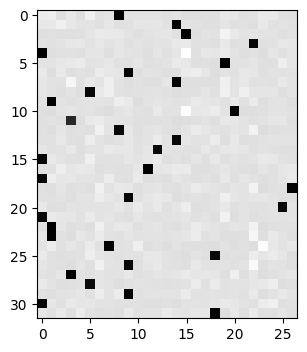

In [37]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [40]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [42]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape


(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [41]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break


In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))